In [1]:
import tensorflow as tf
from tensorflow.keras import backend as K
import segmentation_models as sm
import os
from gan_module.model.build_model import build_generator_non_unet as build_generator
from gan_module.model.build_model import build_discriminator
gpu_on = False
DRAW_IMAGES = True
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

if gpu_on :
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    gpu_devices = tf.config.experimental.list_physical_devices("GPU")
    for device in gpu_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    gpu_devices = tf.config.experimental.list_physical_devices("CPU")

print(gpu_devices)
    
generator = sm.Unet(backbone_name=BACKBONE, input_shape=(
            None, None, 3), classes=1, activation='sigmoid')

Segmentation Models: using `keras` framework.
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [2]:
from glob import glob
from tensorflow.keras import backend as K
import cv2

from IPython.display import HTML, display
import segmentation_models as sm
from gan_module.util.custom_loss import dice_score, dice_loss, WeightedRegionLoss, TverskyLoss
def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 75%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))


def remove_folder_png_files(folder_path):
    regxp_files = os.path.join(folder_path, "*.png")
    target_files = glob(regxp_files)
    for target_file in target_files:
        os.remove(target_file)
    

def get_filebasename(file_path):
    filename_with_ext = os.path.basename(file_path)
    filename_without_ext = os.path.splitext(filename_with_ext)[0]
    
    return filename_without_ext

def imread(path, channel=None):
    image_byte_stream = open(path.encode("utf-8"), "rb")
    image_byte_array = bytearray(image_byte_stream.read())
    image_numpy_array = np.asarray(image_byte_array, dtype=np.uint8)
    image_numpy_array = cv2.imdecode(image_numpy_array, cv2.IMREAD_UNCHANGED)
    if channel == "bgr":
        image_numpy_array = cv2.cvtColor(image_numpy_array, cv2.COLOR_BGR2RGB)
    if len(image_numpy_array.shape) == 2:
        image_numpy_array = np.expand_dims(image_numpy_array, axis=-1)
    return image_numpy_array



In [3]:
import numpy as np
from tensorflow.keras import backend as K
index = 325
mode = "valid"
data_set_name = "vessel_level_1_512_random_org"
dataset_path = os.path.join("datasets", data_set_name, mode)

generator.load_weights(f'./U_net/{data_set_name}/weights_325_0.0025.hdf5')

imagepath = glob(f"./datasets/{data_set_name}/train/image/*.png")[index]
maskpath = glob(f"./datasets/{data_set_name}/train/mask/*.png")[index]

image = imread(imagepath, channel="bgr")
image = np.array([image])
image_normalized = (image / 127.5) - 1
mask = np.expand_dims(np.round(imread(maskpath) / 255).astype('float32'), axis=0)
predicted = generator.predict(image_normalized)


print(np.unique(mask))
print(np.unique(predicted))

[0. 1.]
[0.0000000e+00 1.1960808e-38 1.1962998e-38 ... 5.9350133e-03 6.2453747e-03
 8.5400641e-03]


In [4]:
# loss_function = weighted_region_TverskyLossloss
loss_function = WeightedRegionLoss()

zero_mask = np.zeros((4,512,512,1), dtype="float32")
one_mask = np.ones((4,512,512,1), dtype="float32")

zero_diff = np.zeros((4,512,512,1), dtype="float32")
zero_diff[:, :100, :100] = 1
one_diff = np.ones((4,512,512,1), dtype="float32")
one_diff[:, :100, :100] = 0
 
print(f"zero_mask equal f1_loss: {loss_function(K.constant(zero_mask), K.constant(zero_mask))}")
print(f"normal_mask equal f1_loss: {loss_function(K.constant(mask), K.constant(mask))}")
print(f"one_mask equal f1_loss: {loss_function(K.constant(one_mask), K.constant(one_mask))}")

print(f"zero_mask diffrent f1_loss: {loss_function(K.constant(zero_mask), K.constant(zero_diff))}")
print(f"normal_mask diffrent f1_loss: {loss_function(K.constant(mask), K.constant(predicted))}")
print(f"one_mask diffrent f1_loss: {loss_function(K.constant(one_mask), K.constant(one_diff))}")

print(f"zero_mask diffrent dice_score: {dice_score(K.constant(zero_mask), K.constant(zero_diff))}")
print(f"normal_mask diffrent dice_score: {dice_score(K.constant(mask), K.constant(predicted))}")
print(f"one_mask diffrent dice_score: {dice_score(K.constant(one_mask), K.constant(one_diff))}")

zero_mask equal f1_loss: -2.3841855067985307e-07
normal_mask equal f1_loss: -2.3841855067985307e-07
one_mask equal f1_loss: -2.3841855067985307e-07
zero_mask diffrent f1_loss: 0.011827641166746616
normal_mask diffrent f1_loss: 0.0009595585870556533
one_mask diffrent f1_loss: 0.011827641166746616
zero_mask diffrent dice_score: 0.0
normal_mask diffrent dice_score: 5.960464477539063e-08
one_mask diffrent dice_score: 0.9805556535720825


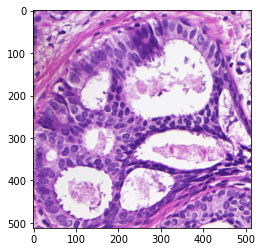

In [5]:
from matplotlib import pyplot as plt

plt.imshow(image[0])

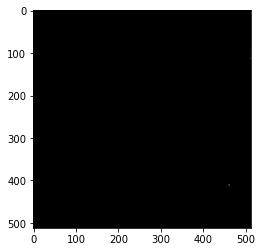

In [6]:
from matplotlib import pyplot as plt

plt.imshow(predicted[0,:,:,0], cmap="gray")

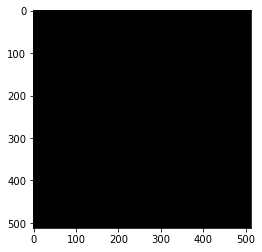

In [7]:
from matplotlib import pyplot as plt

plt.imshow(np.round(predicted[0,:,:,0]), cmap="gray")

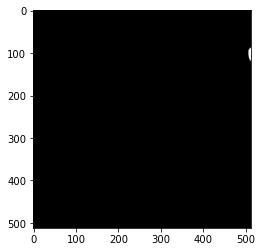

In [8]:
from matplotlib import pyplot as plt

plt.imshow(mask[0,:,:,0], cmap="gray")

In [15]:
import os
import cv2
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
from time import time

import tensorflow_addons as tfa

start = time()

batch_size = 1

test_predict_info = []
mode = "train"

result_path = f"images/{data_set_name}/check_state/{mode}"
os.makedirs(f"{result_path}/f1_score", exist_ok=True)
os.makedirs(f"{result_path}/order", exist_ok=True)
if DRAW_IMAGES:
    remove_folder_png_files(f"{result_path}/f1_score")
    remove_folder_png_files(f"{result_path}/order")

dataset_path = os.path.join("datasets",data_set_name,mode)

img_path_list = glob(os.path.join(dataset_path, "image", '*.png'))
mask_path_list = glob(os.path.join(dataset_path, "mask", '*.png'))
train_data_length = len(img_path_list)

batch_num = train_data_length // batch_size
progressbar = display(progress(0, batch_num), display_id=True)

assert train_data_length % batch_size == 0

for batch_index in range(batch_num):

    img_array_list = [cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
                      for img_path in img_path_list[batch_index * batch_size:(batch_index + 1) * batch_size]]
    img_array_list = [cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                      for img_array in img_array_list]
    img_array_list = np.array(img_array_list)
    img_array_list = (img_array_list / 127.5) - 1
    img_mask_list = [cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
                     for mask_path in mask_path_list[batch_index * batch_size:(batch_index + 1) * batch_size]]
    img_mask_list = np.array(img_mask_list)
    img_mask_list = np.round((img_mask_list / 255)).astype('float32')

    converted_img_list = generator.predict(img_array_list)
    converted_img_list = np.round(converted_img_list).astype('float32')
    predicted_img_list = converted_img_list[:, :, :, 0]

    # get predict_info
    predict_info = []
    for y_true, y_pred in zip(img_mask_list, predicted_img_list):
        y_true_tensor = K.constant(np.expand_dims(y_true, axis=[0,-1]))
        y_pred_tensor = K.constant(np.expand_dims(y_pred, axis=[0,-1]))
        
        predict_info.append({
            'f1_score': dice_score(y_true_tensor, y_pred_tensor),
            'loss': loss_function(y_true_tensor, y_pred_tensor),
            'mask_ratio': np.mean(y_true),
        })
    test_predict_info += predict_info

    # Rescale images 0 - 1
    img_array_list = 0.5 * img_array_list + 0.5

    row_num = 3
    column_num = 1

    for index, (img_array, predict_array, mask_array) in enumerate(zip(img_array_list, predicted_img_list, img_mask_list)):

        current_index = batch_index * batch_size + index
        current_f1_score = np.round_(
            test_predict_info[current_index]['f1_score'], 3)
        current_loss = np.round_(
            test_predict_info[current_index]['loss'], 3)
        predict_array = cv2.cvtColor(predict_array, cv2.COLOR_GRAY2RGB)
        mask_array = cv2.cvtColor(mask_array, cv2.COLOR_GRAY2RGB)

        gen_img = np.stack(
            [img_array, predict_array, mask_array], axis=0)
        if DRAW_IMAGES:

            titles = ["Original", "Model", "Man"]
            fig, axs = plt.subplots(row_num, column_num)
            for row_index in range(row_num):
                axs[row_index].imshow(gen_img[row_index])
                axs[row_index].set_title(titles[row_index])
                axs[row_index].axis("off")
            fig.set_size_inches(12, 12)
            fig.savefig(
                f"images/{data_set_name}/check_state/{mode}/f1_score/{current_f1_score:.3f}_{current_loss:.3f}_{current_index}.png")
            fig.savefig(
                f"images/{data_set_name}/check_state/{mode}/order/{current_index:0>4}_{current_f1_score:.3f}.png")
            plt.close()

    progressbar.update(progress(batch_index + 1, batch_num))

test_f1_scores = [predict_info['f1_score']
                  for predict_info in test_predict_info]

print(f'Max : {np.max(test_f1_scores)}')
print(f'Min :{np.min(test_f1_scores)}')
print(f'Mean :{np.mean(test_f1_scores)}')
print(f'Median :{np.median(test_f1_scores)}')
print(f'Elasped Time : {time()-start}')


Max : 1.0
Min :0.0
Mean :0.9392329454421997
Median :1.0
Elasped Time : 2927.0947053432465


In [9]:
import os
import cv2
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
from time import time

import tensorflow_addons as tfa

start = time()

batch_size = 1

test_predict_info = []
mode = "valid"

result_path = f"images/{data_set_name}/check_state/{mode}"
os.makedirs(f"{result_path}/f1_score", exist_ok=True)
os.makedirs(f"{result_path}/order", exist_ok=True)
if DRAW_IMAGES:
    remove_folder_png_files(f"{result_path}/f1_score")
    remove_folder_png_files(f"{result_path}/order")
dataset_path = os.path.join("datasets",data_set_name,mode)

img_path_list = glob(os.path.join(dataset_path, "image", '*.png'))
mask_path_list = glob(os.path.join(dataset_path, "mask", '*.png'))
train_data_length = len(img_path_list)

batch_num = train_data_length // batch_size
progressbar = display(progress(0, batch_num), display_id=True)

assert train_data_length % batch_size == 0

for batch_index in range(batch_num):

    img_array_list = [cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
                      for img_path in img_path_list[batch_index * batch_size:(batch_index + 1) * batch_size]]
    img_array_list = [cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                      for img_array in img_array_list]
    img_array_list = np.array(img_array_list)
    img_array_list = (img_array_list / 127.5) - 1
    img_mask_list = [cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
                     for mask_path in mask_path_list[batch_index * batch_size:(batch_index + 1) * batch_size]]
    img_mask_list = np.array(img_mask_list)
    img_mask_list = np.round((img_mask_list / 255)).astype('float32')

    converted_img_list = generator.predict(img_array_list)
    converted_img_list = np.round(converted_img_list).astype('float32')
    predicted_img_list = converted_img_list[:, :, :, 0]

    # get predict_info
    predict_info = []
    for y_true, y_pred in zip(img_mask_list, predicted_img_list):
        y_true_tensor = K.constant(np.expand_dims(y_true, axis=[0,-1]))
        y_pred_tensor = K.constant(np.expand_dims(y_pred, axis=[0,-1]))
        
        predict_info.append({
            'f1_score': dice_score(y_true_tensor, y_pred_tensor),
            'loss': loss_function(y_true_tensor, y_pred_tensor),
            'mask_ratio': np.mean(y_true),
        })
    test_predict_info += predict_info

    # Rescale images 0 - 1
    img_array_list = 0.5 * img_array_list + 0.5

    row_num = 3
    column_num = 1

    for index, (img_array, predict_array, mask_array) in enumerate(zip(img_array_list, predicted_img_list, img_mask_list)):

        current_index = batch_index * batch_size + index
        current_f1_score = np.round_(
            test_predict_info[current_index]['f1_score'], 3)
        current_loss = np.round_(
            test_predict_info[current_index]['loss'], 3)
        predict_array = cv2.cvtColor(predict_array, cv2.COLOR_GRAY2RGB)
        mask_array = cv2.cvtColor(mask_array, cv2.COLOR_GRAY2RGB)

        gen_img = np.stack(
            [img_array, predict_array, mask_array], axis=0)
        if DRAW_IMAGES:

            titles = ["Original", "Model", "Man"]
            fig, axs = plt.subplots(row_num, column_num)
            for row_index in range(row_num):
                axs[row_index].imshow(gen_img[row_index])
                axs[row_index].set_title(titles[row_index])
                axs[row_index].axis("off")
            fig.set_size_inches(12, 12)
            fig.savefig(
                f"images/{data_set_name}/check_state/{mode}/f1_score/{current_f1_score:.3f}_{current_loss:.3f}_{current_index}.png")
            fig.savefig(
                f"images/{data_set_name}/check_state/{mode}/order/{current_index:0>4}_{current_f1_score:.3f}.png")
            plt.close()

    progressbar.update(progress(batch_index + 1, batch_num))

test_f1_scores = [predict_info['f1_score']
                  for predict_info in test_predict_info]

print(f'Max : {np.max(test_f1_scores)}')
print(f'Min :{np.min(test_f1_scores)}')
print(f'Mean :{np.mean(test_f1_scores)}')
print(f'Median :{np.median(test_f1_scores)}')
print(f'Elasped Time : {time()-start}')


Max : 1.0
Min :0.0
Mean :0.4561288356781006
Median :0.5593903660774231
Elasped Time : 404.5018434524536


In [ ]:
import os
import cv2
import numpy as np
from glob import glob
from matplotlib import pyplot as plt
from time import time

import tensorflow_addons as tfa

start = time()

batch_size = 1

test_predict_info = []
mode = "test"

result_path = f"images/{data_set_name}/check_state/{mode}"
os.makedirs(f"{result_path}/f1_score", exist_ok=True)
os.makedirs(f"{result_path}/order", exist_ok=True)
if DRAW_IMAGES:
    remove_folder_png_files(f"{result_path}/f1_score")
    remove_folder_png_files(f"{result_path}/order")

dataset_path = os.path.join("datasets",data_set_name,mode)

img_path_list = glob(os.path.join(dataset_path, "image", '*.png'))
mask_path_list = glob(os.path.join(dataset_path, "mask", '*.png'))
train_data_length = len(img_path_list)

batch_num = train_data_length // batch_size
progressbar = display(progress(0, batch_num), display_id=True)

assert train_data_length % batch_size == 0

for batch_index in range(batch_num):

    img_array_list = [cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
                      for img_path in img_path_list[batch_index * batch_size:(batch_index + 1) * batch_size]]
    img_array_list = [cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                      for img_array in img_array_list]
    img_array_list = np.array(img_array_list)
    img_array_list = (img_array_list / 127.5) - 1
    img_mask_list = [cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
                     for mask_path in mask_path_list[batch_index * batch_size:(batch_index + 1) * batch_size]]
    img_mask_list = np.array(img_mask_list)
    img_mask_list = np.round((img_mask_list / 255)).astype('float32')

    converted_img_list = generator.predict(img_array_list)
    converted_img_list = np.round(converted_img_list).astype('float32')
    predicted_img_list = converted_img_list[:, :, :, 0]

    # get predict_info
    predict_info = []
    for y_true, y_pred in zip(img_mask_list, predicted_img_list):
        y_true_tensor = K.constant(np.expand_dims(y_true, axis=[0,-1]))
        y_pred_tensor = K.constant(np.expand_dims(y_pred, axis=[0,-1]))
        
        predict_info.append({
            'f1_score': dice_score(y_true_tensor, y_pred_tensor),
            'loss': loss_function(y_true_tensor, y_pred_tensor),
            'mask_ratio': np.mean(y_true),
        })
    test_predict_info += predict_info

    # Rescale images 0 - 1
    img_array_list = 0.5 * img_array_list + 0.5

    row_num = 3
    column_num = 1

    for index, (img_array, predict_array, mask_array) in enumerate(zip(img_array_list, predicted_img_list, img_mask_list)):

        current_index = batch_index * batch_size + index
        current_f1_score = np.round_(
            test_predict_info[current_index]['f1_score'], 3)
        current_loss = np.round_(
            test_predict_info[current_index]['loss'], 3)
        predict_array = cv2.cvtColor(predict_array, cv2.COLOR_GRAY2RGB)
        mask_array = cv2.cvtColor(mask_array, cv2.COLOR_GRAY2RGB)

        gen_img = np.stack(
            [img_array, predict_array, mask_array], axis=0)
        if DRAW_IMAGES:

            titles = ["Original", "Model", "Man"]
            fig, axs = plt.subplots(row_num, column_num)
            for row_index in range(row_num):
                axs[row_index].imshow(gen_img[row_index])
                axs[row_index].set_title(titles[row_index])
                axs[row_index].axis("off")
            fig.set_size_inches(12, 12)
            fig.savefig(
                f"images/{data_set_name}/check_state/{mode}/f1_score/{current_f1_score:.3f}_{current_loss:.3f}_{current_index}.png")
            fig.savefig(
                f"images/{data_set_name}/check_state/{mode}/order/{current_index:0>4}_{current_f1_score:.3f}.png")
            plt.close('all')

    progressbar.update(progress(batch_index + 1, batch_num))

test_f1_scores = [predict_info['f1_score']
                  for predict_info in test_predict_info]

print(f'Max : {np.max(test_f1_scores)}')
print(f'Min :{np.min(test_f1_scores)}')
print(f'Mean :{np.mean(test_f1_scores)}')
print(f'Median :{np.median(test_f1_scores)}')
print(f'Elasped Time : {time()-start}')


In [7]:
index = 0

img_array = img_array_list[index]
converted_array = converted_img_list[index:index+1]
predicted_array = converted_array[0,:,:,0]
predicted_array = np.round(predicted_array)
mask_array = img_mask_list[index]

In [ ]:
123.68, 116.779, 103.939 58.393, 57.12, 57.375

In [10]:
temp = img_array - [123.68, 116.779, 103.939]
print(np.min(temp))
print(np.max(temp))
temp = temp / [58.393, 57.12, 57.375]
print(np.min(temp))
print(np.max(temp))

-123.68
-102.939
-2.118062096484168
-1.7941437908496731


In [11]:
y_true = np.expand_dims(mask_array, axis=0)
y_pred = np.expand_dims(predicted_array, axis=0)

tp = tf.math.reduce_sum(y_true * y_pred, axis=[1,2])
tn = tf.math.reduce_sum((1-y_true) * (1-y_pred), axis=[1,2])
fp = tf.math.reduce_sum((1-y_true)*y_pred, axis=[1,2])
fn = tf.math.reduce_sum(y_true*(1-y_pred), axis=[1,2])

p = tp / (tp + fp + K.epsilon()) # Precision = tp / tp + fp
r = tp / (tp + fn + K.epsilon()) # Recall = tp / (tp+fn)

f1 = (2*p*r) / (p+r+K.epsilon())

print(K.mean(f1))

tf.Tensor(0.60074574, shape=(), dtype=float32)


In [12]:
y_true = np.expand_dims(mask_array, axis=[0,-1])
y_pred = np.expand_dims(predicted_array, axis=[0,-1])

tp = tf.math.reduce_sum(y_true * y_pred, axis=[1,2,3])
tn = tf.math.reduce_sum((1-y_true) * (1-y_pred), axis=[1,2,3])
fp = tf.math.reduce_sum((1-y_true)*y_pred, axis=[1,2,3])
fn = tf.math.reduce_sum(y_true*(1-y_pred), axis=[1,2,3])

p = tp / (tp + fp + K.epsilon()) # Precision = tp / tp + fp
r = tp / (tp + fn + K.epsilon()) # Recall = tp / (tp+fn)

f1 = (2*p*r) / (p+r+K.epsilon())

print(K.mean(f1))

tf.Tensor(0.60074574, shape=(), dtype=float32)


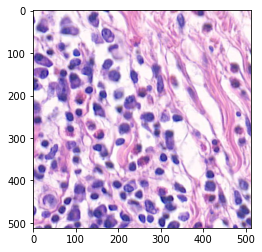

In [13]:
from matplotlib import pyplot as plt

plt.imshow(img_array)
plt.show()

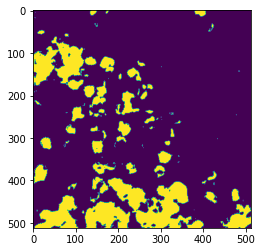

In [14]:
from matplotlib import pyplot as plt

plt.imshow(predicted_array)
plt.show()

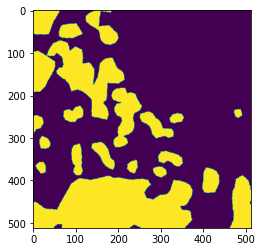

In [15]:
from matplotlib import pyplot as plt

plt.imshow(mask_array)
plt.show()

In [21]:
print(np.min(converted_array))
print(np.max(converted_array))

0.0
1.0


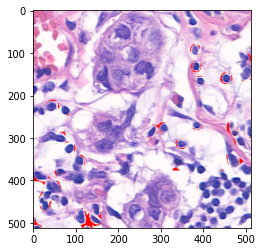

In [151]:
red_mask_img = img_array.copy()
true_negative_array = (1-mask_array) * predicted_array
true_negative_position = np.where(true_negative_array == 1) 
for i,j in zip(*true_negative_position):
    red_mask_img[i,j,0] = 1
    red_mask_img[i,j,1:] = 0

plt.imshow(red_mask_img)
plt.show()

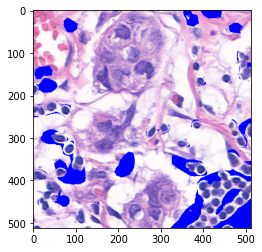

In [152]:
blue_mask_img = img_array.copy()
fail_to_predict_array = mask_array * (1-predicted_array)
fail_to_predict_position = np.where(fail_to_predict_array == 1) 
for i,j in zip(*fail_to_predict_position):
    blue_mask_img[i,j,0:2] = 0
    blue_mask_img[i,j,2] = 1

plt.imshow(blue_mask_img)
plt.show()

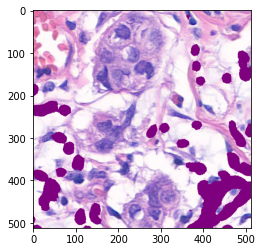

In [153]:
purple_mask_img = img_array.copy()
success_to_predict_array = mask_array * predicted_array
success_to_predict_position = np.where(success_to_predict_array == 1)
for i,j in zip(*success_to_predict_position):
    purple_mask_img[i,j,0] = 0.5
    purple_mask_img[i,j,1] = 0
    purple_mask_img[i,j,2] = 0.5
plt.imshow(purple_mask_img)
plt.show()

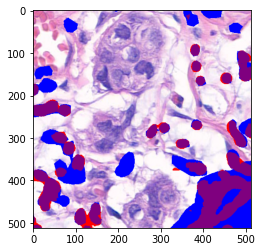

In [155]:
masked_img = img_array.copy()

true_negative_array = (1-mask_array) * predicted_array
true_negative_position = np.where(true_negative_array == 1) 
for i,j in zip(*true_negative_position):
    masked_img[i,j,0] = 1
    masked_img[i,j,1:] = 0
    
fail_to_predict_array = mask_array * (1-predicted_array)
fail_to_predict_position = np.where(fail_to_predict_array == 1) 
for i,j in zip(*fail_to_predict_position):
    masked_img[i,j,0:2] = 0
    masked_img[i,j,2] = 1
    
success_to_predict_array = mask_array * predicted_array
success_to_predict_position = np.where(success_to_predict_array == 1)
for i,j in zip(*success_to_predict_position):
    masked_img[i,j,0] = 0.5
    masked_img[i,j,1] = 0
    masked_img[i,j,2] = 0.5
    
plt.imshow(masked_img)
plt.show()

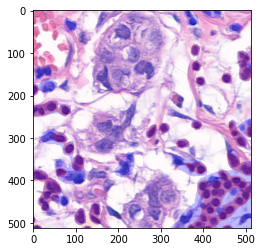

In [154]:
overlayed_img = cv2.addWeighted(red_mask_img, 0.5, img_array, 0.5,0)
overlayed_img = cv2.addWeighted(blue_mask_img, 0.5, overlayed_img, 0.5,0)
overlayed_img = cv2.addWeighted(purple_mask_img, 0.5, overlayed_img, 0.5,0)
plt.imshow(overlayed_img)
plt.show()

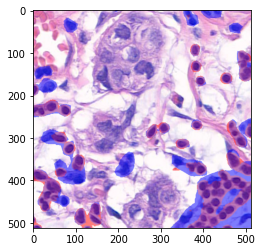

In [158]:
overlayed_img = cv2.addWeighted(masked_img, 0.5, img_array, 0.5,0)
plt.imshow(overlayed_img)
plt.show()

In [ ]:
123.68, 116.779, 103.939 58.393, 57.12, 57.375

In [12]:
import cv2

def imread(path, channel=None):
    image_byte_stream = open(path.encode("utf-8"), "rb")
    image_byte_array = bytearray(image_byte_stream.read())
    image_numpy_array = np.asarray(image_byte_array, dtype=np.uint8)
    image_numpy_array = cv2.imdecode(
        image_numpy_array, cv2.IMREAD_UNCHANGED)

    if channel == 'bgr':
        image_numpy_array = cv2.cvtColor(
            image_numpy_array, cv2.COLOR_BGR2RGB)

    return image_numpy_array

In [47]:
img_array = imread("./datasets/tumor/valid/image/0.png", channel="bgr")

In [40]:
img_array_rgb_sumed[0,0]

630

In [45]:
np.max(img_array)

0

In [49]:
from copy import deepcopy
img_array_rgb_sumed = np.sum(img_array,axis=-1)
temp = deepcopy(img_array)
temp[:,:,0] = temp[:,:,0] / img_array_rgb_sumed

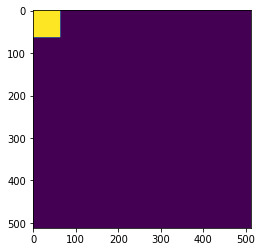

In [1]:
import numpy as np
from matplotlib import pyplot as plt

temp = np.zeros((512,512))
temp[:64, :64] = 1

plt.imshow(temp)

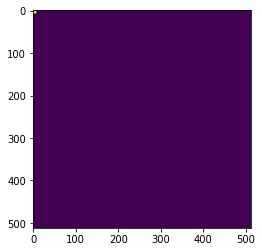

In [2]:
temp = np.zeros((512,512))
temp[:8, :8] = 1

plt.imshow(temp)